A notebook to study the imaging systematics in eBOSS v6 QSO

In [1]:
import os
home=os.getenv('HOME')
scratch = home
home

'/home/mehdi'

In [2]:
import sys
sys.path.append(home + '/github/LSSutils')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import f_regression, mutual_info_regression
from LSSutils.catalogs.combinefits import EBOSSCAT
from LSSutils.catalogs.datarelease import cols_eboss_v6_qso_simp as attrs_names

from sklearn import linear_model
from sklearn.model_selection import train_test_split

camb is not installed!


In [3]:
def F_test(ZCUT):
    sysmaps = pd.read_hdf(scratch + '/data/eboss/sysmaps/SDSS_HI_imageprop_nside256.h5')
    qso = EBOSSCAT([scratch + '/data/eboss/v6/eBOSS_QSO_clustering_NGC_v6.dat.fits'])
    qso.apply_zcut(zcuts=ZCUT)
    qso.project2hp(nside=256)

    ran = EBOSSCAT([scratch + '/data/eboss/v6/eBOSS_QSO_clustering_NGC_v6.ran.fits'], 
                   weights=['weight_noz', 'weight_cp', 'weight_systot'])
    ran.apply_zcut(zcuts=ZCUT)
    ran.project2hp(nside=256)
    
    x    = sysmaps.values
    m    = ran.galm != 0.0
    y    = np.zeros_like(qso.galm)*np.nan
    y[m] = qso.galm[m] / (ran.galm[m] * (qso.galm[m].sum()/ran.galm[m].sum()))


    mydata = pd.DataFrame(np.column_stack([x, y]),
                          columns=attrs_names + ['nqso'])
    mydata.dropna(inplace=True)
    # sns.heatmap(mydata.corr(), cmap=plt.cm.seismic, center=0.0, cbar_kws={'label':'PCC'})
    #
    #  scale the imaging attrs.
    #
    X = mydata.values[:, :-1]
    Y = mydata.values[:, 17]
    X = (X - np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)
    #results = f_regression(X, Y, center=True)
    results = mutual_info_regression(X, Y)
    return results
    #plt.plot(results[1], attrs_names, '.')
    #plt.grid()

In [3]:
#sample1 = F_test([0.8, 1.1])

In [4]:
#sample2 = F_test([1.5, 2.2])

In [3]:
# plt.plot(sample1/np.max(sample1), attrs_names, '.', ls='--', color='r', label='0.8<z<1.1', lw=0.5)
# plt.plot(sample2/np.max(sample2), attrs_names, 'x', ls='-', color='k', label='1.5<z<2.2', lw=0.5)
# plt.legend(bbox_to_anchor=(1.3, 1.))
# plt.xlabel('Mutual Information value')
# plt.grid()

In [3]:
ls $scratch/data/eboss/v6_elnet

eBOSS_QSO_clustering_NGC_v6.dat.fits         nn-weights_NGChigh.hp256.fits
eBOSS_QSO_clustering_NGC_v6.ran.fits         nn-weights_NGClow.hp256.fits
eBOSS_QSO_clustering_NGC_v6_zelnet.dat.fits  nn-weights_SGChigh.hp256.fits
eBOSS_QSO_clustering_SGC_v6.dat.fits         nn-weights_SGClow.hp256.fits
eBOSS_QSO_clustering_SGC_v6.ran.fits         params_valMSENGC.png
eBOSS_QSO_clustering_SGC_v6_zelnet.dat.fits  params_valMSE.png
elnet_models_NGC.npy                         params_valMSESGC.png
elnet_models_SGC.npy


In [7]:
def elastic_regression(ZCUT, cap, verbose=False, nside=256):
    sysmaps = pd.read_hdf(scratch + '/data/eboss/sysmaps/SDSS_HI_imageprop_nside256.h5')
    qso = EBOSSCAT([scratch + '/data/eboss/v6_elnet/eBOSS_QSO_clustering_'+cap+'_v6_zelnet.dat.fits'],
                  ['weight_noz', 'weight_cp', 'weight_systot'])
    qso.apply_zcut(zcuts=ZCUT)
    qso.project2hp(nside=256)

    ran = EBOSSCAT([scratch + '/data/eboss/v6/eBOSS_QSO_clustering_'+cap+'_v6.ran.fits'], 
                   weights=['weight_noz', 'weight_cp', 'weight_systot'])
    ran.apply_zcut(zcuts=[0.8, 2.2])
    ran.project2hp(nside=256)
    
    x    = sysmaps.values
    m    = ran.galm != 0.0
    y    = np.zeros_like(qso.galm)*np.nan
    y[m] = qso.galm[m] / (ran.galm[m] * (qso.galm[m].sum()/ran.galm[m].sum()))


    mydata = pd.DataFrame(np.column_stack([x, y]),
                          columns=attrs_names + ['nqso'])
    mydata.dropna(inplace=True)
    # sns.heatmap(mydata.corr(), cmap=plt.cm.seismic, center=0.0, cbar_kws={'label':'PCC'})
    #
    #  scale the imaging attrs.
    #
    #print(mydata.shape)
    hpix = mydata.index
    
    X = mydata.values[:, :-1]
    Y = mydata.values[:, 17]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=0.33, 
                                                        random_state=42)
    
    meanX, stdX = np.mean(X_train, axis=0), np.std(X_train, axis=0, ddof=1)
    meanY, stdY = np.mean(Y_train), np.std(Y_train, ddof=1)
    
    X_train = (X_train - meanX)/stdX
    X_test  = (X_test  - meanX)/stdX
    #Y_train = (Y_train - meanY)/stdY
    #Y_test  = (Y_test - meanY)/stdY    
    
    #alphas    = [0.0001, 0.001, 0.01, 0.1, 1.]
    mse_base  = np.mean((Y_test - meanY)**2)
    
    alphas    = np.logspace(-3, -1, num=12, endpoint=True)
    coef_list = []
    mse_list  = []
    for alpha_i in alphas:#, 0.001, 0.01, 0.1, 1.]:
        reg = linear_model.ElasticNet(alpha=alpha_i)
        reg.fit(X_train, Y_train)  
        Y_pred = reg.predict(X_test)
        mse = np.mean((Y_pred - Y_test)**2)
        mse_list.append(mse)
        coef_list.append(reg.coef_)
        if verbose:print('%.4f %.4f %.4f'%(alpha_i, mse, mse_base))
    # run with the best
    alpha_best = alphas[np.argmin(mse_list)]
    reg = linear_model.ElasticNet(alpha=alpha_best)
    reg.fit(X_train, Y_train)  
    Y_pred = reg.predict(X_test)
    mse = np.mean((Y_pred - Y_test)**2)    
    
    # make the weight maps 
    Xtot    = (X - meanX)/stdX
    wmap    = np.zeros(12*nside*nside)*np.nan
    wmap[mydata.index] = reg.predict(Xtot)
    results = dict(alphas=alphas, coefs=np.column_stack(coef_list), mses=mse_list,
                   mse_best=mse, mse_base=mse_base, coef_best=reg.coef_, alpha_best=alpha_best,
                   wmap=wmap)
    return results

In [8]:
def run(title='NGC', regression='lasso'):
    if regression == 'lasso':        
        results1 = lasso_regression([0.8, 1.1],   title, verbose=True)
        results2 = lasso_regression([1.5, 2.2],   title, verbose=True)    
    elif regression == 'elastic':
        results1 = elastic_regression([0.8, 1.1], title, verbose=True)
        results2 = elastic_regression([1.5, 2.2], title, verbose=True)    
        
    #
    colors = plt.cm.jet
    fig, ax = plt.subplots(nrows=2, figsize=(8, 10), sharex=True)
    plt.subplots_adjust(hspace=0.0)


    ax[0].set_title('%s-%s solid (0.8<z<1.1) dashed (1.5<z<2.2)'%(title, regression))
    for i in range(17):
        ax[0].plot(-np.log(results1['alphas']), results1['coefs'][i,:], 
                   label=attrs_names[i], c=colors(i/17), linestyle='-')
        ax[0].plot(-np.log(results2['alphas']), results2['coefs'][i,:], 
                   linestyle='--', c=colors(i/17))
    ax[0].legend(bbox_to_anchor=(1., 1.))
    ax[0].set_ylabel('parameters')

    ax[1].plot(-np.log(results1['alphas']), 1.e3*(results1['mses']/np.min(results1['mses'])-1), 'k-', label='0.8<z<1.1')
    ax[1].plot(-np.log(results2['alphas']), 1.e3*(results2['mses']/np.min(results2['mses'])-1), 'k--', label='1.5<z<2.2')
    ax[1].set_xlabel('- log(alpha)')
    ax[1].set_ylabel('1.e4 [ Validation MSE - 1]')
    ax[1].legend()
    plt.show()

len of gal cats 1
num of gal obj 216893
going to apply z-cuts : [0.8, 1.1]
num of gal obj after cut 36796
projecting into a healpix map with nside of 256
len of gal cats 1
num of gal obj 5565871
going to apply z-cuts : [0.8, 2.2]
num of gal obj after cut 5565871
projecting into a healpix map with nside of 256
0.0010 1.9915 1.9915
0.0015 1.9915 1.9915
0.0023 1.9915 1.9915
0.0035 1.9915 1.9915
0.0053 1.9915 1.9915
0.0081 1.9915 1.9915
0.0123 1.9915 1.9915
0.0187 1.9915 1.9915
0.0285 1.9915 1.9915
0.0433 1.9915 1.9915
0.0658 1.9915 1.9915
0.1000 1.9915 1.9915
len of gal cats 1
num of gal obj 216893
going to apply z-cuts : [1.5, 2.2]
num of gal obj after cut 109942
projecting into a healpix map with nside of 256
len of gal cats 1
num of gal obj 5565871
going to apply z-cuts : [0.8, 2.2]
num of gal obj after cut 5565871
projecting into a healpix map with nside of 256
0.0010 0.8347 0.8345
0.0015 0.8347 0.8345
0.0023 0.8346 0.8345
0.0035 0.8346 0.8345
0.0053 0.8345 0.8345
0.0081 0.8345 0.8345

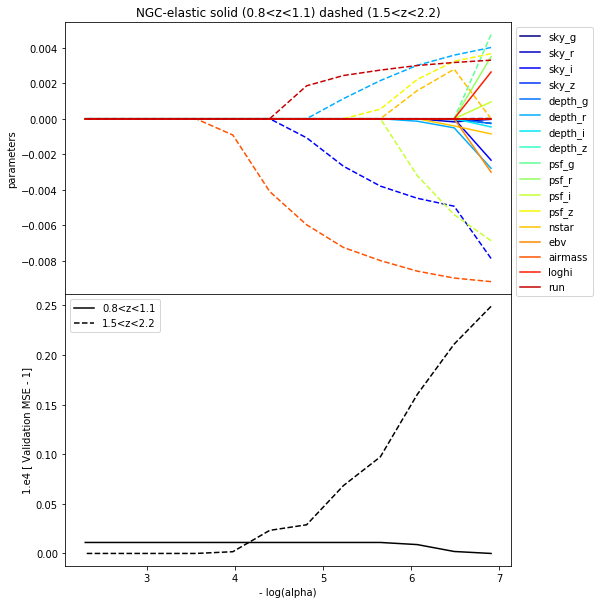

In [9]:
run('NGC', 'elastic')

len of gal cats 1
num of gal obj 125501
going to apply z-cuts : [0.8, 1.1]
num of gal obj after cut 20835
projecting into a healpix map with nside of 256
len of gal cats 1
num of gal obj 3587326
going to apply z-cuts : [0.8, 2.2]
num of gal obj after cut 3587326
projecting into a healpix map with nside of 256
0.0010 3.1268 3.1267
0.0015 3.1268 3.1267
0.0023 3.1268 3.1267
0.0035 3.1268 3.1267
0.0053 3.1267 3.1267
0.0081 3.1267 3.1267
0.0123 3.1267 3.1267
0.0187 3.1267 3.1267
0.0285 3.1267 3.1267
0.0433 3.1267 3.1267
0.0658 3.1267 3.1267
0.1000 3.1267 3.1267
len of gal cats 1
num of gal obj 125501
going to apply z-cuts : [1.5, 2.2]
num of gal obj after cut 64760
projecting into a healpix map with nside of 256
len of gal cats 1
num of gal obj 3587326
going to apply z-cuts : [0.8, 2.2]
num of gal obj after cut 3587326
projecting into a healpix map with nside of 256
0.0010 2.3212 2.3197
0.0015 2.3211 2.3197
0.0023 2.3210 2.3197
0.0035 2.3207 2.3197
0.0053 2.3205 2.3197
0.0081 2.3202 2.3197


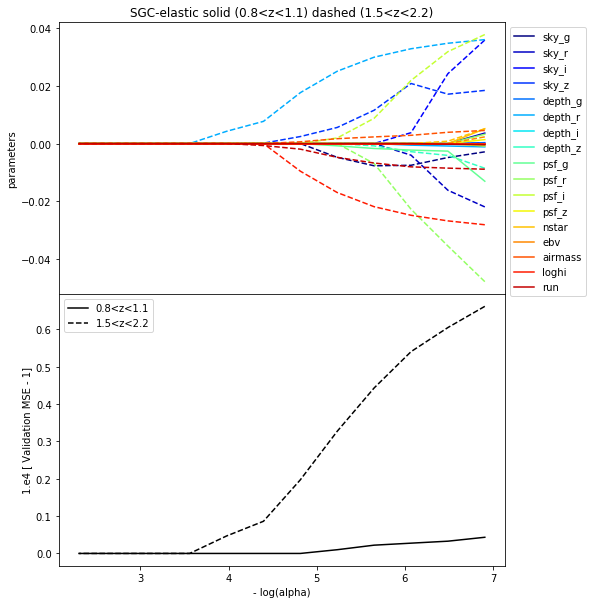

In [10]:
run('SGC', 'elastic')

In [11]:
import matplotlib.pyplot as plt
import nbodykit.lab as nb

In [12]:
plt.rc('font', size=18)

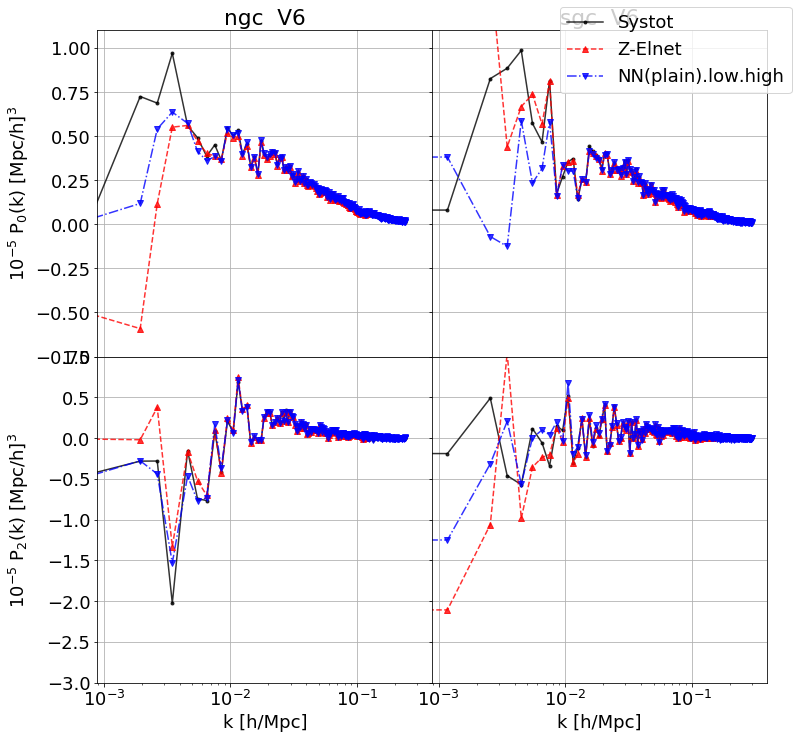

In [18]:
c   = ['k', 'r', 'b', 'purple', 'orange']
ls  = ['-', '--', '-.', ':', '-']
mk  = ['.', '^', 'v', 'x', 'o']
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 12), sharey='row', sharex=True)
plt.subplots_adjust(hspace=0., wspace=0)
ax = ax.flatten()

for j,cap in enumerate(['ngc', 'sgc']):
    CAP = cap.upper()
    path = '/home/mehdi/data/eboss/v6/results_'+cap+'.all/clustering/'
    wsystot      = nb.ConvolvedFFTPower.load(path + 'pk_v6_wsystot_512.json')
    welnet      = nb.ConvolvedFFTPower.load('/home/mehdi/data/eboss/v6_elnet/pk_'+CAP+'_zelnet_512.json')
    #wsystotnn    = nb.ConvolvedFFTPower.load(path + 'pk_v6_wnn_abv2_512.json')
    #wsystotnnp   = nb.ConvolvedFFTPower.load(path + 'pk_v6_wnn_p_512.json')
    wosystot     = nb.ConvolvedFFTPower.load(path + 'pk_v6_512.json')
    wsystotnnz   = nb.ConvolvedFFTPower.load(path + 'pk_v6_wnnz_p_512.json')    
    #wsystotnnz2   = nb.ConvolvedFFTPower.load(path + 'pk_v6_wnnz_abv2_512.json')    
    #pks = [wsystot, wsystotnnp, wsystotnnz, wsystotnnz2, wsystotnn]
    #ttl = ['w/ sys_tot', 'w/ NN', 'w/ NN-low.high', 'w/ NN-low.high w ab', 'w/ NN w ab']
    #pks = [wsystot,  wsystotnnp, wsystotnnz, wsystotnn, wsystotnnz2]
    #ttl = ['w/ sys_tot', 'w/ NN (plain)', 'w/ NN-low.high (plain)', 'w/ NN', 'w/ NN-low.high' ]
    pks = [wsystot, welnet, wsystotnnz]
    ttl = ['Systot', 'Z-Elnet', 'NN(plain).low.high']

    for i,data in enumerate(pks):    
        err = 1.e-5*data.poles['power_0'].real/(0.5*data.poles['modes'])**0.5
        #ax[j].errorbar(data.poles['k'], 1.e-5*(data.poles['power_0'].real-data.attrs['shotnoise']), yerr=err,
        #           label=ttl[i], ls=ls[i], c=c[i], marker=mk[i], alpha=0.8)
        ax[j].plot(data.poles['k'], 1.e-5*(data.poles['power_0'].real-data.attrs['shotnoise']),
                 label=ttl[i], ls=ls[i], c=c[i], marker=mk[i], alpha=0.8)
    for i,data in enumerate(pks):    
        ax[2+j].plot(data.poles['k'], 1.e-5*data.poles['power_2'].real,
                    label=ttl[i], ls=ls[i], c=c[i], marker=mk[i], alpha=0.8)        
    # j = 0, 1
    ax[j].set_xscale('log')
    ax[j].set_ylim(-.75, 1.1)
    ax[2+j].set_ylim(-3, 1)
    ax[2+j].set_xlabel(r'k [h/Mpc]')
    ax[j].set_title(cap + '  V6')
    if j==0:
        ax[j].set_ylabel(r'10$^{-5}$ P$_{0}$(k) [Mpc/h]$^{3}$')
        ax[2+j].set_ylabel(r'10$^{-5}$ P$_{2}$(k) [Mpc/h]$^{3}$')
    if j == 1:ax[j].legend(bbox_to_anchor=(1.1, 1.1))
for a in ax:a.grid()
fig.align_labels()   
plt.show()
#plt.savefig('P0_P2.pdf', bbox_inches='tight')